In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [9]:
# CONSTANTS
img_height = 128
img_width = 128
channels = 3
factor_size = 8


In [17]:
def split_data(images, annotations, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], annotations[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], annotations[indices[train_samples:]]
    return x_train, y_train, x_valid, y_valid


def get_single_frame(img_path, annotation_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float16)
    img = tf.image.resize(img, [img_height, img_width])

    label_img = tf.io.read_file(annotation_path)
    label_img = tf.image.decode_jpeg(label_img, channels=channels)
    label_img = tf.image.convert_image_dtype(label_img, tf.float16)
    label_img = tf.image.resize(label_img, [img_height, img_width])

    return {"image": img, "annotated_img": label_img}


In [18]:
# data preparation
DATA_DIR = "./data"
images_dir = Path(os.path.join(DATA_DIR, "images"))
annotation_dir = Path(os.path.join(DATA_DIR, "annotations"))

In [19]:
images = sorted(list(map(str, list(images_dir.glob("*")))))
annotations = sorted(list(map(str, list(annotation_dir.glob("*")))))

In [20]:
batch_size = 32
x_train, y_train, x_valid, y_valid = split_data(np.array(images), np.array(annotations), train_size=0.8)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_dataset = (
    valid_dataset.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

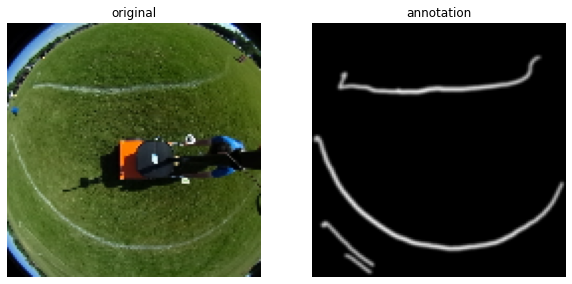

In [23]:
# check some data
def see_train_data(idx=0):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    for batch in train_dataset.take(idx):
        image = batch["image"][0]
        ax[0].imshow((image * 255).numpy().astype("uint8"))
        ax[0].set_title("original")
        ax[0].axis("off")

        annotated_img = batch["annotated_img"][0]
        ax[1].imshow((annotated_img * 255).numpy().astype("uint8"))
        ax[1].set_title("annotation")
        ax[1].axis("off")

see_train_data(1)


In [8]:
# preprocessing
# add (rotated, darkened, lightened, flipped, etc) data to the dataset


In [31]:
# model
input_img = layers.Input(shape=(img_width, img_height, channels), name='input_img')

x = layers.Conv2D(32, (3, 3), padding='same', name='Conv_1')(input_img)
x = layers.MaxPooling2D((2, 2), name='MaxPool_1')(x)
x = layers.BatchNormalization(name='BatchNorm_1')(x)

x = layers.Conv2D(64, (3, 3), padding='same', name='Conv_2')(x)
x = layers.MaxPooling2D((2, 2), name='MaxPool_2')(x)
x = layers.BatchNormalization(name='BatchNorm_2')(x)

x = layers.Conv2D(128, (3, 3), padding='same', name='Conv_3')(x)
x = layers.MaxPooling2D((2, 2), name='MaxPool_3')(x)
x = layers.BatchNormalization(name='BatchNorm_3')(x)

x = layers.Conv2DTranspose(64, 3, padding='same', name='ConvT_1')(x)
x = layers.BatchNormalization(name='BatchNormT_1')(x)
x = layers.UpSampling2D(2, name='UpSampleT_1')(x)

x = layers.Conv2DTranspose(64, 3, padding='same', name='ConvT_2')(x)
x = layers.BatchNormalization(name='BatchNormT_2')(x)
x = layers.UpSampling2D(2, name='UpSampleT_2')(x)

x = layers.Conv2DTranspose(32, 3, padding='same', name='ConvT_3')(x)
x = layers.BatchNormalization(name='BatchNormT_3')(x)
x = layers.UpSampling2D(2, name='UpSampleT_3')(x)

output_img = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name='Conv_Last')(x)

model = keras.models.Model(input_img, output_img)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 128, 128, 3)]     0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 64, 64, 32)        0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 64, 64, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
BatchNorm_2 (BatchNormalizat (None, 32, 32, 64)       

In [32]:
# train
epochs = 1
model.fit(train_dataset, epochs=epochs)



ValueError: in user code:

    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer Conv_1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 1]
